In [145]:
import sys
import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print(sys.version.replace('\n', ''), torch.__version__, torch.version.cuda)

3.7.3 (default, Feb 24 2020, 01:25:29) [GCC 8.3.0] 1.4.0 10.1


In [2]:
![ -f tiny_nerf_data.npz ] || curl -O https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


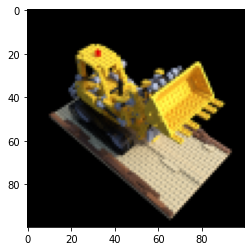

In [3]:
data = np.load('tiny_nerf_data.npz')
imgs, poses, focal = data['images'], data['poses'], data['focal']
H, W = imgs.shape[1:3]
print(imgs.shape, poses.shape, focal)

testimg, testpose = imgs[101], poses[101]
imgs, poses = imgs[:100], poses[:100]

plt.imshow(testimg)

In [16]:
POSENC_LEN = 6
def posenc(theta):
    theta = torch.as_tensor(theta)[...,None]
    harmonics = theta * 2**torch.arange(POSENC_LEN).float().to(theta.device)
    return torch.cat([theta, torch.sin(harmonics), torch.cos(harmonics)], dim=-1)

In [17]:
INPUT_SZ = posenc(torch.zeros(3)).numel()
OUTPUT_SZ = 4

In [155]:
WIDTH = 256
#ACT = lambda: nn.LeakyReLU(inplace=True)
ACT = lambda: nn.PReLU()

def dense(in_sz, out_sz, act=True):
    fc = nn.Linear(in_sz, out_sz, bias=True)
    return nn.Sequential(fc, ACT()) if act else fc
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Sequential(
            dense(INPUT_SZ, WIDTH),
            *[dense(WIDTH, WIDTH) for _ in range(3)],
        )
        self.fc1 = nn.Sequential(
            dense(WIDTH+INPUT_SZ, WIDTH),
            *[dense(WIDTH, WIDTH) for _ in range(3)],
            dense(WIDTH, OUTPUT_SZ, act=False),
        )
    def forward(self, x):
        inp = x
        x = self.fc0(x)
        x = self.fc1(torch.cat([x, inp], dim=-1))
        return x

In [166]:
def get_rays(H, W, focal, pose):
    j, i = torch.meshgrid(torch.arange(H).float(), torch.arange(W).float())
    dirs = torch.stack([(i-W/2)/focal, -(j-H/2)/focal, -torch.ones_like(i)], dim=-1)
    rays_d = torch.sum(dirs[...,None,:].to(pose.device) * pose[:3,:3], dim=-1)
    rays_o, _ = torch.broadcast_tensors(pose[:3,-1], rays_d)
    return rays_o, rays_d

In [130]:
def batchify(fn, chunk):
    def inner(x):
        outs = []
        for i in range(0, x.size(0), chunk):
            outs.append(fn(x[i:i+chunk]))
        return torch.cat(outs, dim=0)
    return inner

In [131]:
def excumprod(x, dim):
    ones_sz = list(x.size())
    ones_sz[dim] = 1
    ones = torch.ones(*ones_sz, dtype=x.dtype).to(x.device)
    slices = [slice(None)] * len(x.size())
    slices[dim] = slice(-1)
    x = torch.cat([ones, x[tuple(slices)]], dim=dim)
    return torch.cumprod(x, dim=dim)

In [137]:
CHUNK = 1024*32
def render_rays(model, rays_o, rays_d, near, far, n_samples, add_noise=False):
    
    # sample along rays
    z_vals = torch.linspace(near, far, steps=n_samples).to(rays_o.device)
    z_vals = z_vals.expand(*(rays_o.shape[:-1] + (-1,))).clone()
    if add_noise:
        z_vals += torch.rand_like(z_vals) * (far-near)/n_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,None]
    
    # run model
    pts_flat = posenc(pts).view(-1, INPUT_SZ)
    raw = batchify(model, CHUNK)(pts_flat).view(*(pts.shape[:-1] + (OUTPUT_SZ,)))
    
    # compute opacities & colors
    sigma_a = F.relu(raw[...,3])
    rgb = torch.sigmoid(raw[...,:3])
    
    # volume rendering
    dists = torch.cat([
        z_vals[...,1:]-z_vals[...,:-1], 
        1e10*torch.ones_like(z_vals[...,:1])], dim=-1)
    alpha = 1. - torch.exp(-sigma_a * dists)
    weights = alpha * excumprod(1.-alpha+1e-10, dim=-1)
    
    rgb_map = torch.sum(weights[...,None] * rgb, dim=-2)
    depth_map = torch.sum(weights * z_vals, dim=-1)
    
    return rgb_map, depth_map

iter 0/501 (0.00 sec/iter) loss: 0.00


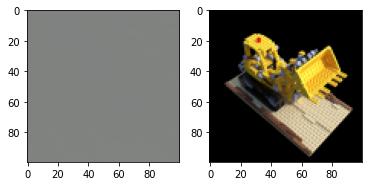

iter 50/501 (0.23 sec/iter) loss: 115399.15


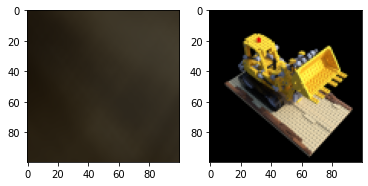

iter 100/501 (0.23 sec/iter) loss: 62279.74


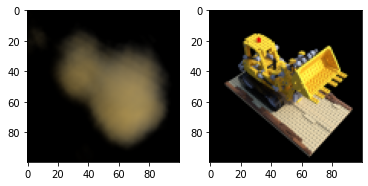

iter 150/501 (0.23 sec/iter) loss: 38458.01


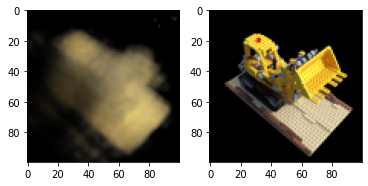

iter 200/501 (0.23 sec/iter) loss: 35386.49


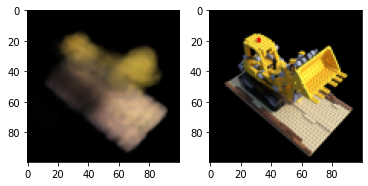

iter 250/501 (0.23 sec/iter) loss: 23769.64


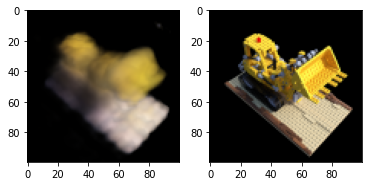

iter 300/501 (0.23 sec/iter) loss: 18085.90


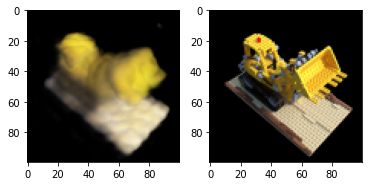

iter 350/501 (0.23 sec/iter) loss: 18350.50


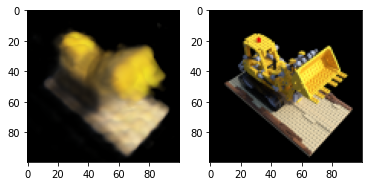

iter 400/501 (0.23 sec/iter) loss: 17992.43


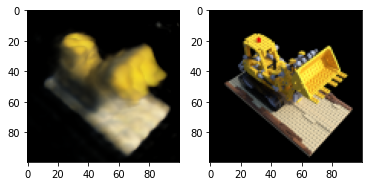

iter 450/501 (0.23 sec/iter) loss: 16949.19


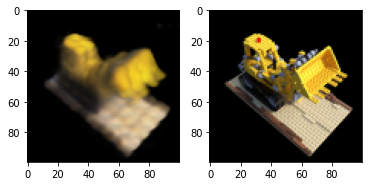

iter 500/501 (0.23 sec/iter) loss: 14908.83


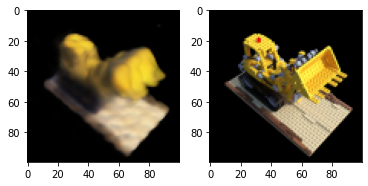

In [157]:
N_SAMPLES = 32
N_ITERS = 501
PLOT_ITERS = 50

model = Model()
model.cuda()

def train():
    model.train()
    opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    t0 = time.time()
    total_loss = 0.
    for i in range(N_ITERS):
        
        if i % PLOT_ITERS == 0:
            t1 = time.time()
            print(f'iter {i}/{N_ITERS} ({(t1-t0)/PLOT_ITERS:.2f} sec/iter) loss: {total_loss:.2f}')
            t0 = t1
            total_loss = 0.
            
            model.eval()
            rays_o, rays_d = get_rays(H, W, focal, torch.tensor(testpose))
            with torch.no_grad():
                rgb, depth = render_rays(model, rays_o.cuda(), rays_d.cuda(),
                    near=2., far=6., n_samples=N_SAMPLES)

            rgb_cpu = rgb.cpu().numpy()
            plt.subplot(121)
            plt.imshow(rgb.cpu().numpy())
            plt.subplot(122)
            plt.imshow(testimg)
            plt.show()
        
        model.train()

        idx = np.random.randint(imgs.shape[0])
        img, pose = torch.as_tensor(imgs[idx]), torch.as_tensor(poses[idx])
        rays_o, rays_d = get_rays(H, W, focal, pose)

        img, rays_o, rays_d = [x.cuda() for x in (img, rays_o, rays_d)]

        opt.zero_grad()
        rgb, depth = render_rays(model, rays_o, rays_d, 
            near=2., far=6., n_samples=N_SAMPLES, add_noise=True)
        loss = ((rgb-img)**2).sum()
        loss.backward()
        opt.step()
        
        total_loss += loss.item()
            
train()

In [161]:
torch.save(model.state_dict(), 'model.pt')

In [10]:
#model = Model().cuda()
#model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [158]:
def trans_t(t):
    t = torch.as_tensor(t)
    return torch.tensor([
        [1,0,0,0],
        [0,1,0,0],
        [0,0,1,t],
        [0,0,0,1]], dtype=torch.float)

def rot_phi(phi):
    phi = torch.as_tensor(phi)
    return torch.tensor([
        [1,0,0,0],
        [0,torch.cos(phi),-torch.sin(phi),0],
        [0,torch.sin(phi), torch.cos(phi),0],
        [0,0,0,1]], dtype=torch.float)

def rot_theta(theta):
    theta = torch.as_tensor(theta)
    return torch.tensor([
        [torch.cos(theta),0,-torch.sin(theta),0],
        [0,1,0,0],
        [torch.sin(theta),0, torch.cos(theta),0],
        [0,0,0,1]], dtype=torch.float)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]).float() @ c2w
    return c2w

In [258]:
from IPython.display import HTML
from base64 import b64encode
import imageio
def show_vid(frames, path='video.mp4'):
    imageio.mimwrite(path, frames, fps=30, quality=7)
    mp4 = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
    """ % data_url)

In [199]:
N_SAMPLES = 32
frames = []
model.eval()
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    with torch.no_grad():
        rgb, depth = render_rays(model, rays_o.cuda(), rays_d.cuda(), near=2., far=6., n_samples=N_SAMPLES)
    frames.append((255*np.clip(rgb.cpu().numpy(),0,1)).astype(np.uint8))
show_vid(frames)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (100, 100) to (112, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).



making vid


In [176]:
# make sure the gradient flows
model.eval()
# gpose = gradient pose
gpose = torch.as_tensor(testpose).cuda().requires_grad_(True)
rays_o, rays_d = get_rays(H, W, focal, gpose)
rgb, depth = render_rays(model, rays_o, rays_d,
    near=2., far=6., n_samples=N_SAMPLES)
loss = torch.sum((torch.as_tensor(testimg).cuda() - rgb)**2)
loss.backward()
gpose.grad

tensor([[  128.3781,  -228.5546,  -856.3094,   165.3479],
        [  253.0767,   169.8627, -2646.6357,   749.1019],
        [   66.6694,   130.7842, -2725.4299,   708.8219],
        [    0.0000,     0.0000,     0.0000,     0.0000]], device='cuda:0')

In [219]:
from scipy.spatial.transform import Rotation
def mat2quat(r):
    # scalar last
    return Rotation.from_matrix(r).as_quat().astype(np.float32)
def quat2mat(q):
    rows = [
        [1 - 2*q[1]**2 - 2*q[2]**2, 2*q[0]*q[1] - 2*q[2]*q[3], 2*q[0]*q[2] + 2*q[1]*q[3]],
        [2*q[0]*q[1] + 2*q[2]*q[3], 1 - 2*q[0]**2 - 2*q[2]**2, 2*q[1]*q[2] - 2*q[0]*q[3]],
        [2*q[0]*q[2] - 2*q[1]*q[3], 2*q[1]*q[2] + 2*q[0]*q[3], 1 - 2*q[0]**2 - 2*q[1]**2],
    ]
    return torch.stack([torch.stack(row, dim=0) for row in rows], dim=0)

In [222]:
r0 = testpose[:3,:3]; print(r0, r0.dtype)
q = mat2quat(r0); print(q)
r1 = quat2mat(torch.tensor(q)); print(r1)
print((r1-r0)**2)

[[ 6.8935126e-01  5.3373039e-01 -4.8982298e-01]
 [-7.2442728e-01  5.0788772e-01 -4.6610624e-01]
 [ 1.4901163e-08  6.7615211e-01  7.3676193e-01]] float32
[ 0.33342966 -0.14298125 -0.36726114  0.8564463 ]
tensor([[ 0.6894,  0.5337, -0.4898],
        [-0.7244,  0.5079, -0.4661],
        [ 0.0000,  0.6762,  0.7368]])
tensor([[3.5527e-15, 3.1974e-14, 3.5527e-15],
        [0.0000e+00, 3.5527e-15, 3.5527e-15],
        [2.2204e-16, 0.0000e+00, 3.5527e-15]])


In [244]:
# make quaternion unit, ignoring graph
def forceunit(q):
    mag = (q.data**2).sum().sqrt()
    q.data.div_(mag)

In [260]:
# opt gpose

R_NOISE = 1e-2
T_NOISE = 5e-1

model.eval()
orig_q = torch.tensor(mat2quat(testpose[:3,:3])).cuda()
orig_t = torch.tensor(testpose[:3,-1]).cuda()

gpose_q = orig_q.clone()
r_noise = torch.randn_like(gpose_q) * R_NOISE
print('r_noise:', r_noise)
gpose_q += r_noise
forceunit(gpose_q)
gpose_q.requires_grad_(True)

gpose_t = orig_t.clone()
t_noise = torch.randn_like(gpose_t) * T_NOISE
print('t_noise:', t_noise)
gpose_t += t_noise
gpose_t.requires_grad_(True)

gpose_opt = optim.Adam([gpose_q, gpose_t], lr=1e-3)
cimg = torch.as_tensor(testimg).cuda()
frames = []
for j in range(20):
    print('vid', j)
    for i in range(200):
        t_err = torch.sum((gpose_t.detach()-orig_t)**2)
        r_err = torch.sum((gpose_q.detach()-orig_q)**2)
        #print(f'iter {i:02} t_err: {t_err:.3e} r_err: {r_err:.3e}')
        #print(orig_gpose[:3,:3].shape, gpose_t[:,None].shape)
        #gpose = torch.cat([orig_gpose[:3,:3], gpose_t[:,None]], dim=-1)
        gpose = torch.cat([quat2mat(gpose_q), gpose_t[:,None]], dim=-1)
        #print(gpose)
        gpose = torch.cat([gpose, torch.tensor([[0.,0.,0.,1.]]).cuda()], dim=0)
        rays_o, rays_d = get_rays(H, W, focal, gpose)
        rgb, depth = render_rays(model, rays_o, rays_d,
            near=2., far=6., n_samples=N_SAMPLES)
        loss = torch.sum((cimg-rgb)**2)
        gpose_opt.zero_grad()
        loss.backward()
        gpose_opt.step()
        forceunit(gpose_q)
        err_img = (cimg.detach()-rgb.detach()).abs().sum(dim=-1) / 3
        err_img = torch.stack([err_img, err_img, err_img], dim=-1)
        #print(rgb.shape, loss_img.shape)
        frame = torch.cat([rgb.detach(), err_img], dim=1)
        frames.append((np.clip(frame.cpu().numpy(), 0, 1)*255).astype(np.uint8))
    show_vid(frames, path='localize'+str(j)+'.mp4')

r_noise: tensor([ 0.0068,  0.0152, -0.0131,  0.0023], device='cuda:0')
t_noise: tensor([0.1511, 0.5320, 0.1735], device='cuda:0')
vid 0


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 1


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 2


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 3


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 5


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 6


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 7


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 8


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 9


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 10


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 11


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 12


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 13


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 14


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 15


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 16


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 17


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 18


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


vid 19


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 100) to (208, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [243]:
torch.tensor([1.,2,3]).sum().sqrt()

tensor(2.4495)